# Vertaler Nederlands naar Fries

Doel van deze notebook is het encoder en decoder gedeelte van het model uitbreiden om de accuracy te verhogen. In het vorige versies heb ik extra lagen in de encoder en decoder gestopt (in aparte notebooks) om te kijken wat voor verschil dit maakt op basis van het model van Chollet. In de encoder bleef de accuracy het zelfde maar in de decoder ging de accuracy omhoog. 

In [1]:
#Alle imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from wordcloud import WordCloud #pip install wordcloud
import string
import re

## 1. Business Understanding

Versie business understanding: 1.0
### 1.1 Business objectives
#### 1.1.1 Background
De Friese taal is een erkende taal door de Nederlandse staat. Mensen die in Friesland wonen hebben recht om het vak Fries te krijgen. Omdat de taal erkend is door Nederlandse staat mag deze taal gebruikt worden in Friesland bij overheidsgebouwen, rechtbanken en scholen om er een paar instanties te noemen. Doordat de Friese taal steeds minder wordt gesproken door mensen is er een te kort ontstaan. Bijvoorbeeld er zijn geen Friese tolken meer voor de rechtbanken, Friese media kan geen nieuwe journalisten vinden die de taal goed beheersen en instanties die hun brieven alleen in het Fries versturen.  

Omdat er verschillende problemen met de Friese taal in de praktijk wordt er in dit project alleen gefocust op het vertalen van teksten tussen Nederlands en Fries.

Bronnen: 
- https://ukrant.nl/provincie-fryslan-zet-rug-voor-het-blok-wij-doen-mee-of-wij-gaan-weg/
- https://www.ad.nl/binnenland/laatste-tolk-fries-verdwijnt-uit-rechtbank-leeuwarden-overheid-wil-niet-onderhandelen-over-tarief~ac8f6c5d/ 
- https://nos.nl/nieuwsuur/artikel/2116603-friese-taal-met-uitsterven-bedreigd
- https://www.omropfryslan.nl/nl/nieuws/963226/wetenschappers-friese-taal-als-we-ons-vakgebied-willen-redden-moet-er-nu-actie-komen 

#### 1.1.2 Business objective
Zoals uit 1.1 Background is gebleken wordt er alleen gefocust op het vertalen van teksten. De hoofdvraag van dit project luidt daarom als: “Kan er een machine learning model komen die een betrouwbare vertaling kan maken tussen Nederlands en Fries zodat deze in de praktijk kan worden gebruikt om brieven te vertalen”.

#### 1.1.3 Business success criteria (KSF)
De succes criteria van het project moeten een positieve uitkomst hebben om het project te vervolgen. Om de succes criteria te benoemen: 
- Inzichten over de bruikbaarheid van de geleverde data
- Inzichten over wat voor soort machine learning model potentie heeft om succesvol brieven te vertalen

### 1.2 Assess situation
#### 1.2.1 Resources
Voor dit project is er een CSV-bestand vrijgegeven van 170.000 vertalingen van Nederlands naar Fries. Daarbij is ook de manier vrijgegeven hoe de data is gegenereerd. De data is afkomstig van de Fryske Akademy. 

Naast de data zijn er ook twee GitHub pagina’s gedeeld. De eerste GitHub pagina gaat over het model van Chollet. Dit model gaat als basis dienen voor het model wat opgeleverd gaat worden. De tweede GitHub pagina is voor een embeddings laag van het model. Hiermee kan het model getraind worden op Nederlands wat de prestaties van het model misschien positief kan beïnvloeden.    
#### 1.2.2 Requirements, assumptions, and constraints
**Requirements**
- De duur van het project is één week.
- Er moeten inzichten komen over de data
- Er moet een werkend model zijn
- Er hoeft geen rekening gehouden met de beveiliging van de data

**Assumptions**
- Voor het model moet de techniek bidirectional van Keras worden gebruikt omdat de volgorde van de zinnen een groot invloed kunnen hebben op de prestaties van het model
- De data kan foutieve vertalingen bevatten

**Constrains**
- De enige constrain voor dit project is dat het trainen van de modellen lang kan duren omdat de hardware waarmee gewerkt zou worden nog niet klaarstaat.

### 1.3 Determine data mining goal
#### 1.3.1 Data mining goal
Om aan de business objective te voldoen worden er notebooks opgeleverd die laat zien hoe het model werkt en de kwaliteit van de geleverde data.
#### 1.3.2 Data mining success criteria (KPI)
Om de data mining goals te voldoen moet het notebook aan de volgende criteria voldoen:
- Bekend het doel van het notebooks
- Uitgebreide data understanding
- Een werkend model 
- Een evaluatie van het notebook wat de volgende stappen kunnen zijn om het model te verbeteren en bevindingen worden vermeld  

## 2. Data Understanding
Versie data understanding: 1.0

In [2]:
df = pd.read_csv('dataset/dataset.csv')

In [3]:
df.head()

,nederlands,fries
0,we hebben de burgemeester het advies gegeven o...,wy hawwe de boargemaster it advys jun om it ka...
1,we hebben de burgemeester het advies gegeven o...,wy hawwe de boargemaster it advys jun om it ka...
2,een plotselinge dood,in hastige dea
3,een plotselinge dood,in unferwachte dea
4,zijn plotseling overlijden,syn hastich ferstjerren


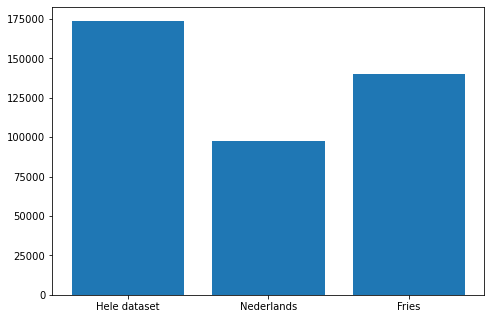

In [4]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
cat = ['Hele dataset', 'Nederlands', 'Fries']
result = [len(df), df['nederlands'].nunique(), df['fries'].nunique()]
ax.bar(cat, result)
plt.show()

In [5]:
df.describe().transpose()

,count,unique,top,freq
nederlands,173912,97496,eigenlijk moeten we bruinbrood eten na twee da...,192
fries,173912,139791,trije by fiif trije by fjouwer meter,32


192 keer komt dezelfde Nederlandse zin voor?


### eigenlijk moeten we bruinbrood eten na twee dagen

In [6]:
df['nederlands'].value_counts().idxmax()

'eigenlijk moeten we bruinbrood eten na twee dagen begint het gejammer over verstopping en opgezette buiken'

In [7]:
df_temp = df[df.eq('eigenlijk moeten we bruinbrood eten na twee dagen begint het gejammer over verstopping en opgezette buiken').any(1)]

In [8]:
df_temp.describe().transpose()

,count,unique,top,freq
nederlands,192,1,eigenlijk moeten we bruinbrood eten na twee da...,192
fries,192,192,eins moatte wy brune ite nei twa dagen begjint...,1


In [9]:
pd.options.display.max_colwidth = 100
df_temp['fries']

83802      eins moatte wy brune ite nei twa dagen begjint it jammerjen oer ferstopping en opsette buken
83803      eins moatte wy brune ite nei twa dagen begjint it jammerjen oer ferstopping en opsette liven
83804        eins moatte wy brune ite nei twa dagen begjint it jammerjen oer ferstoppe en opsette buken
83805        eins moatte wy brune ite nei twa dagen begjint it jammerjen oer ferstoppe en opsette liven
83806           eins moatte wy brune ite nei twa dagen begjint it jammerjen oer sitten en opsette buken
                                                      ...                                              
83989    eins moatte wy oan e kuchbole nei twa dagen begjint it seuren oer ferstopping en opsette liven
83990      eins moatte wy oan e kuchbole nei twa dagen begjint it seuren oer ferstoppe en opsette buken
83991      eins moatte wy oan e kuchbole nei twa dagen begjint it seuren oer ferstoppe en opsette liven
83992         eins moatte wy oan e kuchbole nei twa dagen begjin

Ziet er logisch uit omdat er steeds andere woorden worden gebruikt die het zelfde kunnen betekenen.

### trije by fiif trije by fjouwer meter

In [10]:
df['fries'].value_counts().idxmax()

'trije by fiif trije by fjouwer meter'

In [11]:
df_temp = df[df.eq('trije by fiif trije by fjouwer meter').any(1)]

In [12]:
df_temp.describe().transpose()

,count,unique,top,freq
nederlands,32,32,twee bij vier twee bij vier centimeter,1
fries,32,1,trije by fiif trije by fjouwer meter,32


In [13]:
pd.options.display.max_colwidth = 100
df_temp['nederlands']

95841    twee bij vier twee bij vier centimeter
95873         twee bij vier twee bij vier meter
95905    twee bij vier twee bij vijf centimeter
95937         twee bij vier twee bij vijf meter
95969    twee bij vier drie bij vier centimeter
96001         twee bij vier drie bij vier meter
96033    twee bij vier drie bij vijf centimeter
96065         twee bij vier drie bij vijf meter
96097    twee bij vijf twee bij vier centimeter
96129         twee bij vijf twee bij vier meter
96161    twee bij vijf twee bij vijf centimeter
96193         twee bij vijf twee bij vijf meter
96225    twee bij vijf drie bij vier centimeter
96257         twee bij vijf drie bij vier meter
96289    twee bij vijf drie bij vijf centimeter
96321         twee bij vijf drie bij vijf meter
96353    drie bij vier twee bij vier centimeter
96385         drie bij vier twee bij vier meter
96417    drie bij vier twee bij vijf centimeter
96449         drie bij vier twee bij vijf meter
96481    drie bij vier drie bij vier cen

Hier is iets misgegaan. De zin in het Nederlands is "drie bij vijf drie bij vier meter". Ik zie dat er veel getallen verkeerd gaan en dat er opeens centimer (sintimeter) staat in plaats van meter.

### Aantal woorden in kollomen checken

In [14]:
print(df["nederlands"].apply(lambda n: len(n.split())).min())
print(df["fries"].apply(lambda n: len(n.split())).min())

1
1


In [15]:
print(df["nederlands"].apply(lambda n: len(n.split())).max())
print(df["fries"].apply(lambda n: len(n.split())).max())

59
60


In [16]:
print(df["nederlands"].apply(lambda n: len(n.split())).mean())
print(df["fries"].apply(lambda n: len(n.split())).mean())

9.066044896269378
9.237137172823036


Zie hier niks geks in.

### Lengte van strings in kollomen checken

In [17]:
print(df['nederlands'].str.len().min())
print(df['fries'].str.len().min())

3
1


In [18]:
print(df['nederlands'].str.len().max())
print(df['fries'].str.len().max())

390
354


In [19]:
print(df['nederlands'].str.len().mean())
print(df['fries'].str.len().mean())

54.407154192925155
51.81316412898477


Raar om te zien dat er in de Friese kolom de laagste waarde 1 is wanneer in de Nederlandse kolom dit 3 is.

In [20]:
s_length = df['fries'].str.len()
bool_mask = (s_length == s_length.min())
df['fries'][bool_mask]

170636    e
Name: fries, dtype: object

In [21]:
s_length = df['nederlands'].str.len()
bool_mask = (s_length == s_length.min())
df['nederlands'][bool_mask]

14756     los
23982     zit
23983     zit
44224     wie
167656    een
167657    een
167658    een
167659    een
Name: nederlands, dtype: object

In [22]:
df.iloc[170636]

nederlands    in de wandeling
fries                       e
Name: 170636, dtype: object

Oke dit is dus gewoon 1 grote fout in de dataset maar is er maar is dit maar een speciaal geval of geldt dit ook voor "woorden" met 2 letters? Het Nederlandse gedeelte geloof ik wel maar het Friese gedeelte maakt mij zorgen.

mask source: https://www.skytowner.com/explore/getting_shortest_and_longest_strings_in_pandas_dataframe

In [23]:
s_length = df['fries'].str.len()
bool_mask = (s_length == 2)
df[bool_mask]

,nederlands,fries
1941,iets van,in
28392,als volgt,sa
35796,op deze wijze,sa
35798,op die wijze,sa
35904,op zodanige wijze,sa
39036,te eniger tijd,ea
42190,einde,ut
42477,ten einde,om
44224,wie,wa
45367,door en door,yn


Waardes met 2 zien er niet geloofwaardig uit. Na Google translate gebruik te hebben kan ik zeggen dat deze aanname klopt.

In [24]:
s_length = df['fries'].str.len()
bool_mask = (s_length == 3)
df[bool_mask]

,nederlands,fries
1940,iets van,san
13382,niet minder dan,wol
14756,los,los
14974,half wilde duif,gib
23982,zit,sit
26060,zeker iemand,ien
26139,vast en zeker,wis
26154,zeker weten,wis
28039,of niet,wel
50675,om reden dat,omt


Waardes met 3 zien er geloofwaardiger uit maar na wat woorden in Google translate te hebben gegooid zie ik wel rare uitkomsten. Zoals bij per kilo/ons/pond wordt er gezegd dat dat het allemaal uns of pun is. Bij ons kan ik uns nog wel voorstellen maar niet bij de rest.

In [25]:
s_length = df['fries'].str.len()
bool_mask = (s_length == 4)
df[bool_mask]

,nederlands,fries
1946,iets dergelijks,soks
3175,uitbundig lachen,geie
5920,in aanzienlijke mate,tige
5923,in belangrijke mate,tige
5926,in grote mate,tige
...,...,...
167596,om het,om 5
167602,om halve,om 5
167608,om uur,om 5
167614,om half,om 5


De eerste 5 kloppen na het opzoeken maar de laatste 5 zien er weer raar uit.

In [26]:
s_length = df['fries'].str.len()
bool_mask = (s_length == 5)
df[bool_mask]

,nederlands,fries
165,het doel treffen,sitte
1521,in het bezit zijn van,hawwe
1778,ten eerste,earst
1939,iets van,sawat
1948,iets dergelijks,lyksa
...,...,...
168823,gedurende korte tijd,koart
169103,voor korte tijd,koart
169317,zelfstandige zonder personeel,zzper
170628,een wandeling maken,kuier


Deze zien er wel meer geloofwaardiger dus ik denk dat de treshhold van 5 karakters het minimum moet zijn voor de dataset. 

In [27]:
s_length = df['nederlands'].str.len()
bool_mask = (s_length == s_length.min())
df[bool_mask]

,nederlands,fries
14756,los,los
23982,zit,sit
23983,zit,sitte
44224,wie,wa
167656,een,healwei
167657,een,ienen
167658,een,tsienen
167659,een,tolven


Eerder zei ik dat ik het Nederlandse gedeelte wel geloofde maar ik was toch nieuwsgierig. Nadat ik dit checkte zag ik direct dat "een" 3 keer verkeerd gaat. Alleen "ienen" is correct de andere 3 woorden zijn half, tien en twaalf.

In [28]:
s_length = df['nederlands'].str.len()
bool_mask = (s_length == 4)
df[bool_mask]

,nederlands,fries
17551,heus,echt
17552,heus,wier
71048,kijk,sjoch
104636,o ja,o ja
150911,over,oer
154823,goed,goed
154824,goed,no goed
155077,o ja,al
162695,goed,goed prestearje
162696,goed,sterk prestearje


Hier is het zelfde probleem weer dan bij de minimale lengte van een string. Wat mij nu opvalt als ik het met de rest vergelijk is dat het probleem aan het einde van de dataset zich bevindt. Ik gok dat dit rond record 150.000 begint. Mijn aanname is dat er iets mis is gegaan rond die records. 

In [29]:
wc = WordCloud(background_color = 'white')

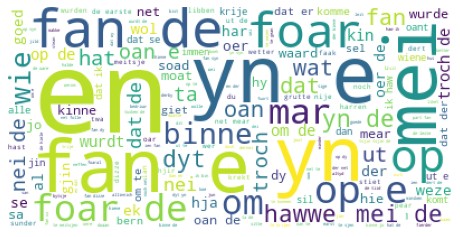

In [30]:
wordcloudFR = wc.generate(' '.join(df['fries']))

plt.figure(figsize=(8,8))
plt.imshow(wordcloudFR)
plt.axis("off")
plt.show()

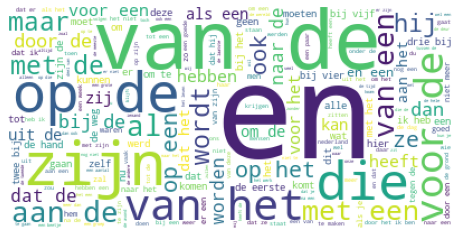

In [31]:
wordcloudNL = wc.generate(' '.join(df['nederlands']))

plt.figure(figsize=(8,8))
plt.imshow(wordcloudNL)
plt.axis("off")
plt.show()

source: https://amueller.github.io/word_cloud/

### Bevindingen
- Er zijn meerdere vertalingen voor dezelfde zinnen
- Bijna 55 procent van de dataset zijn unieke Nederlandse zinnen tegenover 80 procent unieke Frieze zinnen 
- Bij zinnen die vaak voorkomen is waarschijnlijk iets misgegaan zoals bij "trije by fiif trije by fjouwer meter"
- Bij het checken van de lengte van de strings heb ik wel veel rare dingen gezien. Zoals dat het Friese woord 2 letters heeft maar de vertaling is 5 woorden. Frieze strings die korter zijn dan 3 zijn niet geloofwaardig
- Daarnaast ziet het eruit dat de dataset rare waardes heeft na 150.000 records. Het kan zijn dat dit al eerder opspeelt maar dat is dan bij waardes die groter zijn dan 5 wat niet goed te checken is want daar zijn veel records van.


### Rekening meehouden tijdens 3. Data preparation
- Zinnen die vaker voorkomen dan een x getal verwijderen uit de dataset zodat er niet te veel vervuilende data in het model komt  (in een latere versie)
- Kijken wat een goede manier is om een train en validatie set te maken
- Alles boven de 150.000 records verwijderen omdat deze niet correct lijken (in een latere versie)
- Alle Frieze strings die korter dan 3 zijn verwijderen uit de dataset (in een latere versie)

## 3. Data preparation

In [32]:
text_pairs = []

for index, row in df.iterrows():
    text_pairs.append((row['nederlands'], '[start]' + row['fries'] + '[end]'))

In [33]:
np.random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train = text_pairs[:num_train_samples]
val = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test = text_pairs[num_train_samples + num_val_samples:]

In [34]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

In [35]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

In [36]:
vocab_size = 15000
sequence_length = 20

In [37]:
source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [38]:
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

In [39]:
train_dutch_texts = [pair[0] for pair in train]
train_fries_texts = [pair[1] for pair in train]

In [40]:
source_vectorization.adapt(train_dutch_texts)
target_vectorization.adapt(train_fries_texts)

In [41]:
batch_size = 128

In [42]:
def format_dataset(nl, frie):
    nl = source_vectorization(nl)
    frie = target_vectorization(frie)
    return ({
        "dutch": nl,
        "fries": frie[:, :-1],
    }, frie[:, 1:])

In [43]:
def make_dataset(pairs):
    nl_texts, fry_texts = zip(*pairs)
    nl_texts = list(nl_texts)
    fry_texts = list(fry_texts)
    dataset = tf.data.Dataset.from_tensor_slices((nl_texts, fry_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

In [44]:
train_ds = make_dataset(train)
val_ds = make_dataset(val)

In [45]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['dutch'].shape: {inputs['dutch'].shape}")
    print(f"inputs['fries'].shape: {inputs['fries'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['dutch'].shape: (128, 20)
inputs['fries'].shape: (128, 20)
targets.shape: (128, 20)


## 4. Modeling

In [46]:
from tensorflow import keras
from tensorflow.keras import layers

In [47]:
embed_dim = 512
latent_dim = 2048
layer_1 = 1024
layer_2 = 512
layer_3 = 256
layer_4 = 128

In [48]:
source = keras.Input(shape=(None,), dtype="int64", name="dutch")
encoder_emb  = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoder_gru_1 = layers.Bidirectional(layers.GRU(latent_dim, return_sequences=True), merge_mode="sum")(encoder_emb)
encoded_source = layers.GRU(latent_dim)(encoder_gru_1)

In [49]:
past_target = keras.Input(shape=(None,), dtype="int64", name="fries")
decoder_emb  = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru_1 = layers.GRU(latent_dim, return_sequences=True)(decoder_emb, initial_state=encoded_source)
decoder_gru_2 = layers.GRU(layer_1, return_sequences=True)(decoder_gru_1)
decoder_gru_3 = layers.GRU(layer_2, return_sequences=True)(decoder_gru_2)
dropout_2 = layers.Dropout(0.5)(decoder_gru_3)
target_next_step = layers.Dense(vocab_size, activation="softmax")(dropout_2)
seq2seq_rnn = keras.Model([source, past_target], target_next_step)

In [50]:
seq2seq_rnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dutch (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 512)    7680000     ['dutch[0][0]']                  
                                                                                                  
 fries (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, None, 2048)   31481856    ['embedding[0][0]']              
                                                                                              

In [51]:
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history = seq2seq_rnn.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
952/952 [==============================] - 178s 166ms/step - loss: 2.5824 - accuracy: 0.1809 - val_loss: 2.3433 - val_accuracy: 0.2284
Epoch 2/15
952/952 [==============================] - 153s 161ms/step - loss: 2.3286 - accuracy: 0.2386 - val_loss: 2.1629 - val_accuracy: 0.2768
Epoch 3/15
952/952 [==============================] - 154s 162ms/step - loss: 2.1752 - accuracy: 0.2835 - val_loss: 2.0218 - val_accuracy: 0.3237
Epoch 4/15
952/952 [==============================] - 153s 160ms/step - loss: 2.0367 - accuracy: 0.3304 - val_loss: 1.9113 - val_accuracy: 0.3672
Epoch 5/15
952/952 [==============================] - 153s 161ms/step - loss: 1.9253 - accuracy: 0.3717 - val_loss: 1.8111 - val_accuracy: 0.4044
Epoch 6/15
952/952 [==============================] - 153s 160ms/step - loss: 1.8365 - accuracy: 0.4025 - val_loss: 1.7472 - val_accuracy: 0.4272
Epoch 7/15
952/952 [==============================] - 155s 163ms/step - loss: 1.7703 - accuracy: 0.4262 - val_loss: 1.6955 -

## 5. Evaluation

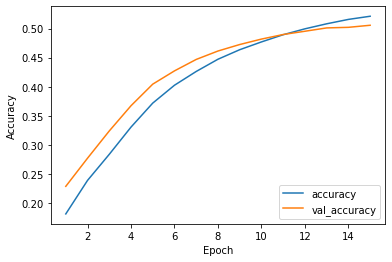

In [52]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1, len(acc)+1)                        
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Het toevoegen van een tweede layer in de encoder heeft de accuracy omlaag gebracht maar de accuracy en de validatie accuracy zijn dichterbij elkaar gekomen. Het is van 0.58% naar 0.5% gegaan.

In de volgende versie ga ik mij focussen om de data preperatie om te kijken als daar nog winst kan gehaald worden op de accuracy.